In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, Add, GlobalAveragePooling2D, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, roc_curve, roc_auc_score,
                             average_precision_score, cohen_kappa_score,
                             matthews_corrcoef, balanced_accuracy_score,
                             jaccard_score, hamming_loss, recall_score, precision_score)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
csv_path = r"Data/Images_Batched.csv" # Ensure this file is in the correct path
HEIGHT = 128
WIDTH = 128
CHANNELS = 1

# User inputs for configuration
BATCHSIZE = int(input("BATCHSIZE (e.g., 64) [default=256]: ") or 256)
EPOCHS = int(input("EPOCHS (e.g., 1024) [default=16]: ") or 16)
subset_percentage = float(input("Subset for training (e.g., 0.05 for 5%) [default=1 for 100%]: ") or 1.0)
train_ratio_config = float(input("Train split ratio (e.g., 0.8 for 80% train) [default=0.8]: ") or 0.8)
test_ratio_config = 1.0 - train_ratio_config

print(f"Configuration: BATCHSIZE={BATCHSIZE}, EPOCHS={EPOCHS}, Subset={subset_percentage*100}%, TrainRatio={train_ratio_config}, TestRatio={test_ratio_config}")

Configuration: BATCHSIZE=64, EPOCHS=4, Subset=100.0%, TrainRatio=0.8, TestRatio=0.19999999999999996


In [ ]:
# --- Inlined data loading and preprocessing logic ---
print("Starting data loading and preprocessing...")
df = pd.read_csv(csv_path)
print(f"Loaded CSV: {len(df)} rows.")

# 1. Labels: MultiLabelBinarizer for Finding_Labels
if "Finding_Labels" in df.columns:
    labels_series = df["Finding_Labels"].fillna("No Finding").str.split('|')
    mlb = MultiLabelBinarizer()
    labels_processed = mlb.fit_transform(labels_series)
    print(f"Processed labels. Unique classes found: {mlb.classes_}")
else:
    labels_processed = None
    print("ERROR: 'Finding_Labels' column not found. This column is essential.")
    raise ValueError("'Finding_Labels' column not found.")

# 2. Features: Initial drop of non-feature/target columns
columns_to_drop_for_features = ["PatientID", "Original_Image_Index", "Finding_Labels"]
feature_df = df.drop(columns=[col for col in columns_to_drop_for_features if col in df.columns])
print(f"Dropped ID/target columns. Remaining feature columns: {feature_df.columns.tolist()}")

# 3. Encoding
if "Patient_Gender" in feature_df.columns:
    gender_map = {'M': 0, 'F': 1, 'O': 2} # O for Other/Unknown, map to a number
    feature_df["Patient_Gender"] = feature_df["Patient_Gender"].map(gender_map).astype("float32")
    if feature_df["Patient_Gender"].isnull().any():
         print(f"Warning: Null values in Patient_Gender after mapping. Filled with -1 (representing unknown).")
         feature_df["Patient_Gender"] = feature_df["Patient_Gender"].fillna(-1) # Fill NaNs created by unmapped values
    print("Processed Patient_Gender.")

if "View_Position" in feature_df.columns:
    view_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore") # handle_unknown='ignore' will create all-zero rows for unknown values
    view_encoded = view_encoder.fit_transform(feature_df[["View_Position"]])
    view_df = pd.DataFrame(view_encoded, columns=view_encoder.get_feature_names_out(["View_Position"]), index=feature_df.index)
    feature_df = pd.concat([feature_df.drop(columns=["View_Position"]), view_df], axis=1)
    print(f"Processed View_Position (OneHotEncoded). New columns: {view_df.columns.tolist()}")

# 4. Standardization
if "Patient_Age" in feature_df.columns:
    # Ensure Patient_Age is numeric, coerce errors to NaN, then fill
    feature_df["Patient_Age"] = pd.to_numeric(feature_df["Patient_Age"], errors='coerce')
    if feature_df["Patient_Age"].isnull().any():
        median_age = feature_df["Patient_Age"].median() # Or mean, or a specific value
        print(f"Warning: Null values in Patient_Age. Filled with median age: {median_age}.")
        feature_df["Patient_Age"] = feature_df["Patient_Age"].fillna(median_age)
    
    age_scaler = StandardScaler()
    feature_df["Patient_Age"] = age_scaler.fit_transform(feature_df[["Patient_Age"]].astype("float32"))
    print("Processed Patient_Age (Standardized).")

# 5. Normalization (MinMax to [0,1] for specified metadata columns)
metadata_cols_to_normalize = [
    "OriginalImage_Width", "OriginalImage_Height",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]
cols_present_for_norm = [col for col in metadata_cols_to_normalize if col in feature_df.columns]
if cols_present_for_norm:
    min_max_scaler = MinMaxScaler()
    try:
        # Ensure columns are numeric and fill NaNs before scaling
        for col in cols_present_for_norm:
            feature_df[col] = pd.to_numeric(feature_df[col], errors='coerce')
            if feature_df[col].isnull().any():
                print(f"Warning: Null values in {col} before MinMax scaling. Filled with 0.") # Or median/mean
                feature_df[col] = feature_df[col].fillna(0) # Example: fill with 0
        
        feature_df[cols_present_for_norm] = feature_df[cols_present_for_norm].astype("float32")
        feature_df[cols_present_for_norm] = min_max_scaler.fit_transform(feature_df[cols_present_for_norm])
        print(f"Normalized metadata columns: {cols_present_for_norm}")
    except Exception as e:
        print(f"Error during metadata normalization for {cols_present_for_norm}: {e}")

# 6. Pixel Data Handling
pixel_col_prefixes = ("pixel_", "Pixels_") # Check your CSV for the exact prefix
pixel_cols = [col for col in feature_df.columns if col.startswith(pixel_col_prefixes)]
print(f"Found {len(pixel_cols)} pixel columns.")

features_image_processed = None
features_tabular_processed = None # Will hold non-pixel features

if pixel_cols:
    max_pixel_value = 255.0
    # IMPORTANT: Set this to the actual max value of your pixel data (e.g., 255 for 8-bit, 4095 for 12-bit, 16383 for 14-bit)
    try:
        # Ensure pixel columns are numeric and fill NaNs (e.g., with 0) before division
        for p_col in pixel_cols:
             feature_df[p_col] = pd.to_numeric(feature_df[p_col], errors='coerce').fillna(0)

        feature_df[pixel_cols] = feature_df[pixel_cols].astype("float32") / max_pixel_value
        image_data_flat = feature_df[pixel_cols].values
        
        print(f'Min-max scaled pixel data shape: {image_data_flat.shape}')
        print(f"Pixel data min: {image_data_flat.min()}, max: {image_data_flat.max()}") 
        print(f"Max pixel value set to: {max_pixel_value}")
        
        expected_pixels = HEIGHT * WIDTH * CHANNELS
        if image_data_flat.shape[1] == expected_pixels:
            features_image_processed = image_data_flat.reshape(-1, HEIGHT, WIDTH, CHANNELS)
            print(f"Reshaped pixel data to: {features_image_processed.shape}")
        else:
            print(f"ERROR: Number of pixel columns ({image_data_flat.shape[1]}) does not match HEIGHT*WIDTH*CHANNELS ({expected_pixels}). Cannot reshape image data.")
            raise ValueError("Pixel data shape mismatch.")
            
    except Exception as e:
        print(f"Error during pixel data processing: {e}")
        raise

    tabular_feature_names = [col for col in feature_df.columns if col not in pixel_cols]
    if tabular_feature_names:
        # Ensure remaining tabular features are numeric, fill NaNs
        for tab_col in tabular_feature_names:
            feature_df[tab_col] = pd.to_numeric(feature_df[tab_col], errors='coerce')
            if feature_df[tab_col].isnull().any():
                print(f"Warning: Null values in tabular column {tab_col}. Filled with 0.")
                feature_df[tab_col] = feature_df[tab_col].fillna(0)
        features_tabular_processed = feature_df[tabular_feature_names].values.astype("float32")
        print(f"Processed tabular features: {features_tabular_processed.shape if features_tabular_processed is not None else 'None'}")
    else: # No other columns left for tabular data
        features_tabular_processed = np.array([]).reshape(len(feature_df),0) # Empty array with correct number of samples
        print("No additional tabular features found besides pixel data.")
        
else: # No pixel columns found
    print("Warning: No pixel columns found with prefixes 'pixel_' or 'Pixels_'. The model expects image data.")
    # If only tabular data is found, this script will likely fail at model creation/training unless the model is adapted.
    # For now, we assume image data is essential.
    raise ValueError("No pixel columns found. Image data is required for the CNN model.")

if features_image_processed is None:
    raise ValueError("Image features (pixel_cols) are missing or failed to process, but the model expects them.")

if len(features_image_processed) != len(labels_processed):
    raise ValueError(f"Inconsistent number of samples between processed images ({len(features_image_processed)}) and labels ({len(labels_processed)}).")

# Final processed data for the next steps:
images_np_array = features_image_processed
# tabular_np_array = features_tabular_processed # Keep this if you plan to use a multi-modal model

print(f"Data loading and preprocessing complete. Image shape: {images_np_array.shape}, Labels shape: {labels_processed.shape}")

Starting data loading and preprocessing...
Loaded CSV: 7500 rows.
Processed labels. Unique classes found: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']
Dropped ID/target columns. Remaining feature columns: ['pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9', 'pixel_10', 'pixel_11', 'pixel_12', 'pixel_13', 'pixel_14', 'pixel_15', 'pixel_16', 'pixel_17', 'pixel_18', 'pixel_19', 'pixel_20', 'pixel_21', 'pixel_22', 'pixel_23', 'pixel_24', 'pixel_25', 'pixel_26', 'pixel_27', 'pixel_28', 'pixel_29', 'pixel_30', 'pixel_31', 'pixel_32', 'pixel_33', 'pixel_34', 'pixel_35', 'pixel_36', 'pixel_37', 'pixel_38', 'pixel_39', 'pixel_40', 'pixel_41', 'pixel_42', 'pixel_43', 'pixel_44', 'pixel_45', 'pixel_46', 'pixel_47', 'pixel_48', 'pixel_49', 'pixel_50', 'pixel_51', 'pixel_52', 'pixel_53', 'pixel_54

In [4]:
# --- Inlined data shuffling, subsetting, and splitting ---
print("Starting data shuffling, subsetting, and splitting...")

if not hasattr(images_np_array, 'shape') or not hasattr(labels_processed, 'shape'):
     raise ValueError("Images or labels are not NumPy-like arrays after processing.")
if len(images_np_array) == 0:
    raise ValueError("Features (images) are empty after processing, cannot proceed.")

images_shuffled, labels_shuffled = shuffle(images_np_array, labels_processed, random_state=42)
print("Shuffled data.")

# Subset
if not (0.0 < subset_percentage <= 1.0):
    raise ValueError("subset_percentage must be between 0 (exclusive) and 1 (inclusive).")
num_total_samples = len(images_shuffled)
subset_size = int(num_total_samples * subset_percentage)

if subset_size == 0:
    if num_total_samples == 0:
         raise ValueError("No data available before applying subset.")
    else: # subset_percentage made it zero
         print(f"Warning: Subset size calculated as 0 with subset_percentage={subset_percentage}. Using 1 sample if available, or all if less than 1/percentage.")
         subset_size = 1 # Try to use at least one sample
if subset_size > num_total_samples : subset_size = num_total_samples # Should not happen if percentage <= 1

images_subset = images_shuffled[:subset_size]
labels_subset = labels_shuffled[:subset_size]
print(f"Applied subset: {len(images_subset)} samples selected for training/testing.")

if len(images_subset) == 0:
    raise ValueError("After applying subset, no data remains. Check subset_percentage and original data size.")

# Stratification logic (attempt)
stratify_option = None
if labels_subset is not None and labels_subset.shape[0] > 1 and test_ratio_config > 0 and test_ratio_config < 1:
    min_samples_per_class_for_split = max(2, int(np.ceil(1/test_ratio_config)), int(np.ceil(1/(1-test_ratio_config))))

    if labels_subset.ndim == 2 and labels_subset.shape[1] > 0:  # Multi-label binarized
        try:
            # For multi-label, stratify by unique combinations of labels
            unique_rows, counts_of_unique_rows = np.unique(labels_subset, axis=0, return_counts=True)
            if len(unique_rows) > 1 and np.all(counts_of_unique_rows >= min_samples_per_class_for_split):
                stratify_option = labels_subset # Use the full label vectors for stratification
                print(f"Stratification enabled for multi-label. Min samples for a unique label combination: {np.min(counts_of_unique_rows)}.")
            else:
                print(f"Warning: Stratification disabled for multi-label. Conditions not met. Smallest unique group has {np.min(counts_of_unique_rows) if len(counts_of_unique_rows)>0 else 'N/A'} samples (need >={min_samples_per_class_for_split}), or only {len(unique_rows)} unique combinations.")
        except Exception as e:
            print(f"Warning: Error during stratification check for multi-label: {e}. Stratification disabled.")
    elif labels_subset.ndim == 1:  # Single-label case
        unique_labels, counts_of_unique_labels = np.unique(labels_subset, return_counts=True)
        if len(unique_labels) > 1 and np.all(counts_of_unique_labels >= min_samples_per_class_for_split):
            stratify_option = labels_subset
            print(f"Stratification enabled for single-label. Min samples for a class: {np.min(counts_of_unique_labels)}.")
        else:
            print(f"Warning: Stratification disabled for single-label. Conditions not met. Smallest class has {np.min(counts_of_unique_labels) if len(counts_of_unique_labels)>0 else 'N/A'} samples (need >={min_samples_per_class_for_split}), or only {len(unique_labels)} classes.")
else:
    print("Stratification not applicable (e.g., no test set, or not enough data).")


# Split data
if test_ratio_config == 0: # Use all subset data for training
    X_train, y_train = images_subset, labels_subset
    X_test, y_test = np.array([]).reshape(0, *images_subset.shape[1:]), np.array([]).reshape(0, *labels_subset.shape[1:])
    print("Using all subset data for training. No test set created from split.")
elif test_ratio_config == 1: # Use all subset data for testing
    X_test, y_test = images_subset, labels_subset
    X_train, y_train = np.array([]).reshape(0, *images_subset.shape[1:]), np.array([]).reshape(0, *labels_subset.shape[1:])
    print("Using all subset data for testing. No training set created from split.")
else: # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        images_subset, labels_subset, test_size=test_ratio_config, random_state=42,
        stratify=stratify_option
    )
print(f"Data split: Training samples: {len(X_train)}, Test samples: {len(X_test)}")

if len(X_train) == 0 and EPOCHS > 0: # If no training data but epochs are set, it's an issue.
    raise ValueError("No training samples available after split, but EPOCHS > 0. Cannot train.")

Starting data shuffling, subsetting, and splitting...
Shuffled data.
Applied subset: 7500 samples selected for training/testing.
Data split: Training samples: 6000, Test samples: 1500


In [5]:
# --- Inlined model definition ---
print("Defining the CNN model...")

# Determine num_classes for model output layer based on y_train or y_test (if y_train is empty)
if len(y_train) > 0:
    num_classes_model = y_train.shape[1] if y_train.ndim == 2 else 1
elif len(y_test) > 0: # If training set is empty but test set exists (e.g. test_ratio_config = 1)
    num_classes_model = y_test.shape[1] if y_test.ndim == 2 else 1
elif len(labels_subset) > 0: # Fallback to labels_subset if y_train/y_test are empty from split
     num_classes_model = labels_subset.shape[1] if labels_subset.ndim == 2 else 1
else: # Fallback to the originally processed labels if all else fails
     num_classes_model = labels_processed.shape[1] if labels_processed.ndim == 2 else 1
print(f"Model will have {num_classes_model} output neuron(s).")

model_input_shape = (HEIGHT, WIDTH, CHANNELS)
inputs = Input(shape=model_input_shape)

# Convolutional Block 1
x = Conv2D(32, (3, 3), padding='same', name='conv1_1')(inputs)
x = BatchNormalization(name='bn1_1')(x)
x = tf.keras.layers.ReLU(name='relu1_1')(x)
x = MaxPooling2D((2, 2), name='pool1')(x)

# Convolutional Block 2
x = Conv2D(64, (3, 3), padding='same', name='conv2_1')(x)
x = BatchNormalization(name='bn2_1')(x)
x = tf.keras.layers.ReLU(name='relu2_1')(x)
x = MaxPooling2D((2, 2), name='pool2')(x)

# Convolutional Block 3
x = Conv2D(128, (3, 3), padding='same', name='conv3_1')(x)
x = BatchNormalization(name='bn3_1')(x)
x = tf.keras.layers.ReLU(name='relu3_1')(x)
x = MaxPooling2D((2, 2), name='pool3')(x)

# Attention Block (Optional, currently not used in original create_model_dynamic)
# If you want to use an attention mechanism, you could insert it here.
# For example:
# att_filters = 128
# attention_output = Attention()([x, x]) # Self-attention
# x = Add()([x, attention_output])
# x = Conv2D(att_filters, (1,1), padding='same', activation='relu')(x) # Optional: further processing

# Convolutional Block 4
x = Conv2D(256, (3, 3), padding='same', name='conv4_1')(x)
x = BatchNormalization(name='bn4_1')(x)
x = tf.keras.layers.ReLU(name='relu4_1')(x)
x = MaxPooling2D((2, 2), name='pool4')(x)

# Head
x = GlobalAveragePooling2D(name='gap')(x)
x = Dropout(0.5, name='dropout_head1')(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_head1')(x)
x = Dropout(0.3, name='dropout_head2')(x)

# Output Layer
if num_classes_model == 1: # Binary classification
    output_layer = Dense(1, activation='sigmoid', name='output_binary')(x)
else: # Multi-label classification
    output_layer = Dense(num_classes_model, activation='sigmoid', name='output_multilabel')(x)

model = Model(inputs, output_layer, name='Chest_XRay_CNN')
model.summary()

Defining the CNN model...
Model will have 15 output neuron(s).
Model: "Chest_XRay_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 128, 128, 32)      320       
                                                                 
 bn1_1 (BatchNormalization)  (None, 128, 128, 32)      128       
                                                                 
 relu1_1 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 64, 64, 64)        18496     
                                                       

In [6]:
# --- Inlined model compilation and training ---
print("Compiling the model...")
model.compile(
    optimizer=Adam(learning_rate=0.00005, clipnorm=1.0),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), # Good for both binary and multi-label with sigmoid
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'), 
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc', multi_label=(num_classes_model > 1), num_labels=num_classes_model if num_classes_model > 1 and num_classes_model is not None else None)
    ]
)

# Learning Rate Scheduler
def lr_schedule(epoch, lr): # lr argument is passed by callback
    if epoch < 50:
        return 0.00005
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000005

# Callbacks
# Adjust monitor metrics if no validation data
val_monitor_metric_acc = 'val_accuracy'
val_monitor_metric_loss = 'val_loss'

if len(X_test) == 0 or len(y_test) == 0: # No validation data
    print("Warning: No validation data available for training. Callbacks will monitor training metrics if applicable.")
    val_monitor_metric_acc = 'accuracy' # Monitor training accuracy instead
    val_monitor_metric_loss = 'loss'   # Monitor training loss instead

callbacks_list = [
    ModelCheckpoint('best_model.h5', monitor=val_monitor_metric_acc, save_best_only=True, verbose=1),
    EarlyStopping(monitor=val_monitor_metric_loss, patience=25, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lr_schedule)
]

# Training
history = None
if len(X_train) > 0 and EPOCHS > 0:
    print(f"Starting model training for {EPOCHS} epochs with batch size {BATCHSIZE}...")
    validation_data_fit = (X_test, y_test) if len(X_test) > 0 and len(y_test) > 0 else None
    
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCHSIZE,
        validation_data=validation_data_fit,
        callbacks=callbacks_list,
        verbose=1
    )
    print("Model training finished.")
elif EPOCHS == 0:
    print("EPOCHS is 0. Skipping model training.")
else: # len(X_train) == 0
    print("No training data (X_train is empty). Skipping model training.")

Compiling the model...
Starting model training for 4 epochs with batch size 64...
Epoch 1/4
94/94 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.3223 - precision: 0.1388 - recall: 0.5975 - auc: 0.5085
Epoch 1: val_accuracy improved from -inf to 0.57333, saving model to best_model.h5
94/94 [==============================] - 17s 80ms/step - loss: 0.8393 - accuracy: 0.3223 - precision: 0.1388 - recall: 0.5975 - auc: 0.5085 - val_loss: 0.8121 - val_accuracy: 0.5733 - val_precision: 0.1598 - val_recall: 0.5156 - val_auc: 0.5000 - lr: 5.0000e-05
Epoch 2/4
93/94 [============================>.] - ETA: 0s - loss: 0.6123 - accuracy: 0.3911 - precision: 0.2678 - recall: 0.3952 - auc: 0.5071
Epoch 2: val_accuracy did not improve from 0.57333
94/94 [==============================] - 6s 68ms/step - loss: 0.6119 - accuracy: 0.3920 - precision: 0.2685 - recall: 0.3954 - auc: 0.5070 - val_loss: 0.7142 - val_accuracy: 0.5733 - val_precision: 0.5733 - val_recall: 0.4624 - val_au

In [7]:
# --- Directory Configuration for Evaluation Outputs ---
# IMPORTANT: Define MAIN_EXPERIMENT_DIR, ideally in an earlier configuration cell (e.g., Cell 2)
# User-defined base directory for all outputs of this specific experiment run
MAIN_EXPERIMENT_DIR = "Output"  # <--- CHANGE THIS to your desired main output folder name

# Generate a timestamp string for the subfolder name
# This will create a unique folder for each run of this cell based on current date and time
timestamp_str = datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss") # e.g., "2025-05-13_19h50m49s"
IMAGEPATH = 'AccLossPlots'
os.makedirs(os.path.join(MAIN_EXPERIMENT_DIR, timestamp_str, IMAGEPATH), exist_ok=True)

Plotting training history (if training was performed)...


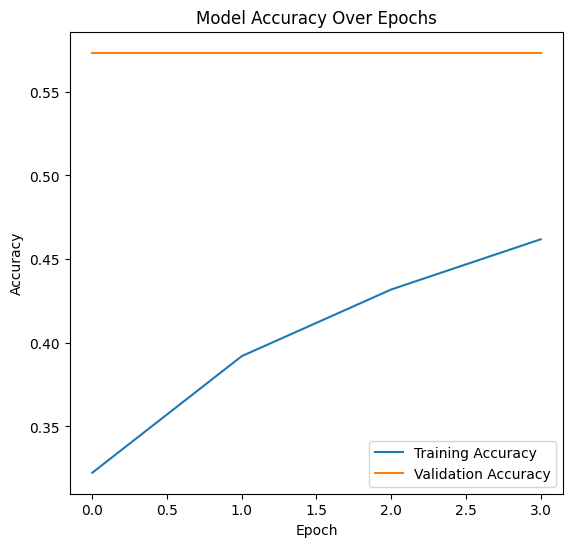

Training history plots saved to 'training_history.png'


In [8]:
# --- Inlined plotting of training history ---
print("Plotting training history (if training was performed)...")
if history is not None and history.history:
    plt.figure(figsize=(14, 6))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    if 'accuracy' in history.history or 'val_accuracy' in history.history:
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No accuracy data to plot.', ha='center', va='center')
        # Loss plot
        plt.subplot(1, 2, 2)
    plt.savefig(os.path.join(MAIN_EXPERIMENT_DIR, timestamp_str, IMAGEPATH,'accuracy_history.png'))
    plt.show()
    plt.close()
    print("Training history plots saved to 'training_history.png'")
else:
    print("Skipping plotting training history: No history object available or history is empty (training likely not performed or failed).")

Plotting training history (if training was performed)...


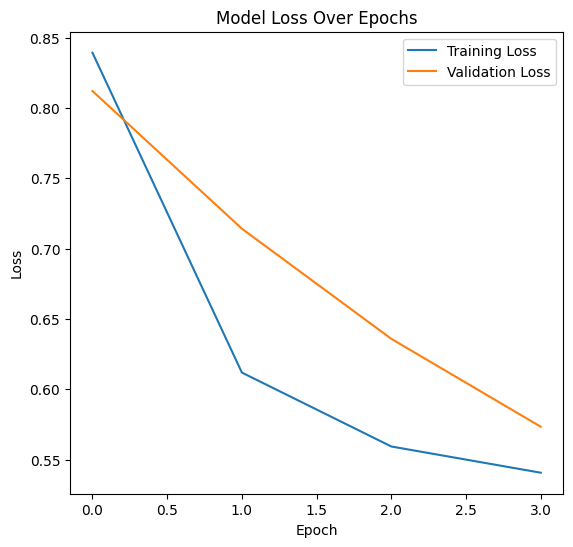

Training history plots saved to 'training_history.png'


In [9]:
# --- Inlined plotting of training history ---
print("Plotting training history (if training was performed)...")
if history is not None and history.history:
    plt.figure(figsize=(14, 6))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    if 'loss' in history.history or 'val_loss' in history.history:
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No loss data to plot.', ha='center', va='center')
        plt.tight_layout()
    plt.savefig(os.path.join(MAIN_EXPERIMENT_DIR, timestamp_str, IMAGEPATH, 'loss_history.png'))
    plt.show()
    plt.close()
    print("Training history plots saved to 'training_history.png'")

else:
    print("Skipping plotting training history: No history object available or history is empty (training likely not performed or failed).")

In [10]:
# --- Inlined model evaluation ---
print("Evaluating model (if test data and model exist)...")
metrics_results = {}

if 'model' in locals() and len(X_test) > 0 and len(y_test) > 0:   
    # Dynamically create the subfolder name for evaluation plots using the timestamp
    EVAL_PLOTS_SUBFOLDER_NAME_WITH_TIMESTAMP = f"evaluation_plots" 
    
    # Construct the full path for evaluation plots
    output_dir_for_this_cell = os.path.join(MAIN_EXPERIMENT_DIR, timestamp_str, EVAL_PLOTS_SUBFOLDER_NAME_WITH_TIMESTAMP)
    
    # Create the directory structure if it doesn't exist
    os.makedirs(output_dir_for_this_cell, exist_ok=True) 
    print(f"Evaluation plots from this cell will be saved to: {os.path.abspath(output_dir_for_this_cell)}")
    # --- End of Directory Configuration ---

    print(f"Evaluating model on {len(X_test)} test samples.")
    y_pred_proba_eval = model.predict(X_test)
    y_pred_eval = (y_pred_proba_eval > 0.5).astype(int) # Thresholding probabilities to get binary predictions
    
    print("\n=== Detailed Classification Report ===")
    target_names_report = None
    if 'mlb' in locals() and hasattr(mlb, 'classes_'): # Check if mlb (MultiLabelBinarizer) is defined and was fit
        target_names_report = mlb.classes_
        
    try:
        # Ensure y_test and y_pred_eval have compatible shapes for classification_report
        print(classification_report(y_test, y_pred_eval, target_names=target_names_report, zero_division=0))
    except ValueError as e_report:
        print(f"Could not generate classification report: {e_report}. Check shapes: y_test {y_test.shape}, y_pred_eval {y_pred_eval.shape}")

    # Confusion Matrix
    print("\nGenerating Confusion Matrices...")
    if num_classes_model == 1: # Binary case
        try:
            cm_eval = confusion_matrix(y_test.ravel(), y_pred_eval.ravel()) 
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix (Binary)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            base_file_name_cm_binary = 'confusion_matrix_binary.png'
            full_save_path_cm_binary = os.path.join(output_dir_for_this_cell, base_file_name_cm_binary)
            plt.savefig(full_save_path_cm_binary)
            print(f"Saved plot to '{full_save_path_cm_binary}'")
            plt.close()
        except ValueError as e_cm:
            print(f"Could not generate binary confusion matrix: {e_cm}")
    else: # Multi-label case
        for i in range(num_classes_model):
            label_name = target_names_report[i] if target_names_report is not None and i < len(target_names_report) else f"Label_{i+1}"
            try:
                cm_label = confusion_matrix(y_test[:, i], y_pred_eval[:, i])
                plt.figure(figsize=(5, 3.5)) 
                sns.heatmap(cm_label, annot=True, fmt='d', cmap='Blues')
                plt.title(f'CM for: {label_name}')
                plt.ylabel('True')
                plt.xlabel('Predicted')
                base_file_name_cm_multi = f'confusion_matrix_{label_name.replace(" ","_").replace("/","_")}.png' 
                full_save_path_cm_multi = os.path.join(output_dir_for_this_cell, base_file_name_cm_multi)
                plt.savefig(full_save_path_cm_multi)
                print(f"Saved plot to '{full_save_path_cm_multi}'")
                plt.close()
            except Exception as e_cml:
                 print(f"Could not generate/save confusion matrix for label {label_name}: {e_cml}")

    # ROC Curve
    print("\nGenerating ROC Curve...")
    plt.figure(figsize=(8, 6))
    if num_classes_model == 1:
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba_eval.ravel())
        roc_auc_val = roc_auc_score(y_test.ravel(), y_pred_proba_eval.ravel())
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    else: 
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba_eval.ravel()) 
        roc_auc_val = roc_auc_score(y_test, y_pred_proba_eval, average='micro', multi_class='ovr') 
        plt.plot(fpr, tpr, label=f'Micro-average ROC (AUC = {roc_auc_val:.3f})')
            
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    base_file_name_roc = 'roc_curve.png'
    full_save_path_roc = os.path.join(output_dir_for_this_cell, base_file_name_roc)
    plt.savefig(full_save_path_roc)
    print(f"Saved plot to '{full_save_path_roc}'")
    plt.close()

    # Precision-Recall Curve
    print("\nGenerating Precision-Recall Curve...")
    plt.figure(figsize=(8, 6))
    if num_classes_model == 1:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test.ravel(), y_pred_proba_eval.ravel())
        average_precision_val = average_precision_score(y_test.ravel(), y_pred_proba_eval.ravel())
        plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {average_precision_val:.3f})')
    else: 
        precision_vals, recall_vals, _ = precision_recall_curve(y_test.ravel(), y_pred_proba_eval.ravel())
        average_precision_val = average_precision_score(y_test, y_pred_proba_eval, average="micro")
        plt.plot(recall_vals, precision_vals, label=f'Micro-average PR (AP = {average_precision_val:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    base_file_name_pr = 'pr_curve.png'
    full_save_path_pr = os.path.join(output_dir_for_this_cell, base_file_name_pr)
    plt.savefig(full_save_path_pr)
    print(f"Saved plot to '{full_save_path_pr}'")
    plt.close()
    
    # Calculate various scalar metrics
    print("\nCalculating Scalar Metrics...")
    try:
      metrics_results['balanced_accuracy'] = balanced_accuracy_score(y_test, y_pred_eval)
    except Exception as e: metrics_results['balanced_accuracy'] = f"Error: {e}"
    metrics_results['precision_micro'] = precision_score(y_test, y_pred_eval, average='micro', zero_division=0)
    metrics_results['recall_micro'] = recall_score(y_test, y_pred_eval, average='micro', zero_division=0)
    metrics_results['f1_micro'] = f1_score(y_test, y_pred_eval, average='micro', zero_division=0)
    
    metrics_results['precision_macro'] = precision_score(y_test, y_pred_eval, average='macro', zero_division=0)
    metrics_results['recall_macro'] = recall_score(y_test, y_pred_eval, average='macro', zero_division=0)
    metrics_results['f1_macro'] = f1_score(y_test, y_pred_eval, average='macro', zero_division=0)
    
    if y_pred_proba_eval is not None:
        try:
            metrics_results['roc_auc_micro_calc'] = roc_auc_score(y_test, y_pred_proba_eval, average='micro', multi_class='ovr')
            metrics_results['roc_auc_macro_calc'] = roc_auc_score(y_test, y_pred_proba_eval, average='macro', multi_class='ovr')
        except ValueError as e_auc: 
            metrics_results['roc_auc_micro_calc'] = f"Not defined ({e_auc})"
            metrics_results['roc_auc_macro_calc'] = f"Not defined ({e_auc})"

        metrics_results['average_precision_micro_calc'] = average_precision_score(y_test, y_pred_proba_eval, average='micro')
        metrics_results['average_precision_macro_calc'] = average_precision_score(y_test, y_pred_proba_eval, average='macro')
            
    if num_classes_model == 1: 
        try:
            metrics_results['kappa'] = cohen_kappa_score(y_test.ravel(), y_pred_eval.ravel())
            metrics_results['mcc'] = matthews_corrcoef(y_test.ravel(), y_pred_eval.ravel())
        except Exception as e_kappa_mcc:
             metrics_results['kappa'] = f"Error: {e_kappa_mcc}"
             metrics_results['mcc'] = f"Error: {e_kappa_mcc}"

    metrics_results['jaccard_micro'] = jaccard_score(y_test, y_pred_eval, average='micro', zero_division=0)
    metrics_results['jaccard_macro'] = jaccard_score(y_test, y_pred_eval, average='macro', zero_division=0)
    metrics_results['hamming_loss'] = hamming_loss(y_test, y_pred_eval)
    
    print("\n=== Final Calculated Metrics Summary ===")
    for key, value in metrics_results.items():
        if isinstance(value, (float, np.float_)): 
            print(f"- {key.replace('_', ' ').capitalize()}: {value:.4f}")
        else:
            print(f"- {key.replace('_', ' ').capitalize()}: {value}")
else:
    print("Skipping model evaluation: Model not trained, or no test data (X_test or y_test is empty).")

print("\n--- End of Script ---")

Evaluating model (if test data and model exist)...
Evaluation plots from this cell will be saved to: c:\Users\shatn\OneDrive\Desktop\GitHubProjects\AI-DR-ASSISTANT-Project\Output\2025-05-14_10h46m11s\evaluation_plots
Evaluating model on 1500 test samples.
47/47 [==============================] - 1s 8ms/step

=== Detailed Classification Report ===
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       139
      Cardiomegaly       0.00      0.00      0.00        51
     Consolidation       0.00      0.00      0.00        64
             Edema       0.00      0.00      0.00        21
          Effusion       0.00      0.00      0.00       143
         Emphysema       0.00      0.00      0.00        23
          Fibrosis       0.00      0.00      0.00        48
            Hernia       0.00      0.00      0.00        10
      Infiltration       0.00      0.00      0.00       251
              Mass       0.00      0.00      0.00 

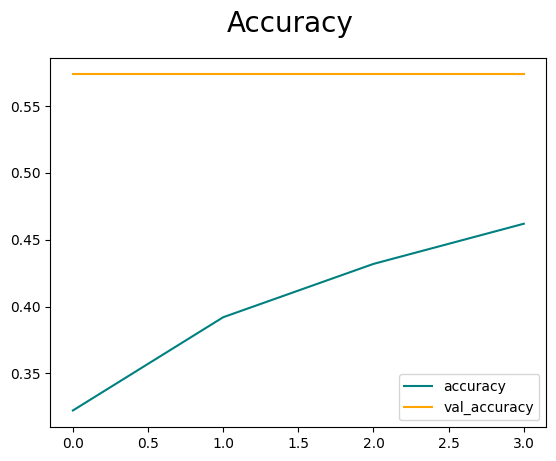

In [11]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right") # 4 options: lower left, lower right, upper left, upper right
plt.show()

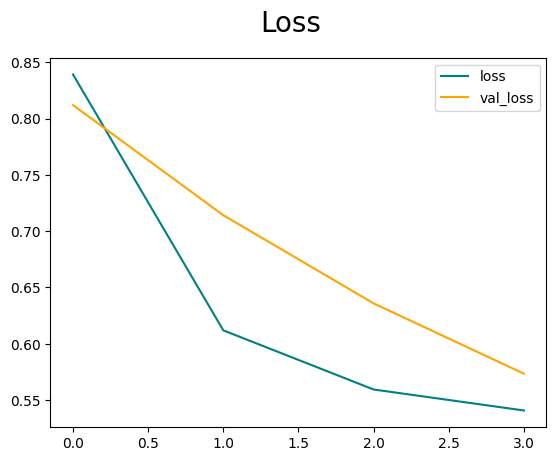

In [12]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right") # 4 options: lower left, lower right, upper left, upper right
plt.show()